In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import os

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm  # or 'en_core_web_trf' for the transformer-based model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 67.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Define constants
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 5e-5
MAX_LENGTH = 128
SAVE_PATH = '/content/drive/MyDrive/CNN_Dataset_Preprocessing/extractive_model'


In [ ]:
# 1. Load dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/CNN_Dataset_Preprocessing/final_cleaned_dataset.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ensure the dataset has necessary columns
assert 'article_sentences' in df.columns and 'summary_sentences' in df.columns, "Required columns missing in dataset."


In [ ]:
# Flatten dataset for sentence-pair training
flattened_data = []
for article, summary in zip(df['article_sentences'], df['summary_sentences']):
    article_sentences = article.split('|')
    summary_sentences = set(summary.split('|'))  # Use set for quick lookup
    for sentence in article_sentences:
        label = 1 if sentence in summary_sentences else 0
        flattened_data.append({'text': sentence, 'label': label})

flattened_df = pd.DataFrame(flattened_data)

In [ ]:
# 2. Split data into training and validation
train_data, val_data = train_test_split(flattened_df, test_size=0.1, random_state=42)


In [ ]:
# 3. Define a custom dataset class
class SummarizationDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        encoding = self.tokenizer(
            row['text'],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(row['label'], dtype=torch.long)
        }


In [ ]:
# 4. Tokenizer and dataset preparation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = SummarizationDataset(train_data, tokenizer, MAX_LENGTH)
val_dataset = SummarizationDataset(val_data, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [ ]:
# 5. Define model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# 6. Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 7. Training loop
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    # Training phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss}")

    # Validation phase
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_acc}")

Epoch 1/3
Training Loss: 0.041704560504417475
Validation Loss: 0.0005592235746527356
Validation Accuracy: 1.0
Epoch 2/3
Training Loss: 0.0005078744888714139
Validation Loss: 0.00028157739767006466
Validation Accuracy: 1.0
Epoch 3/3
Training Loss: 0.0003084237503476049
Validation Loss: 0.00018493611007995372
Validation Accuracy: 1.0


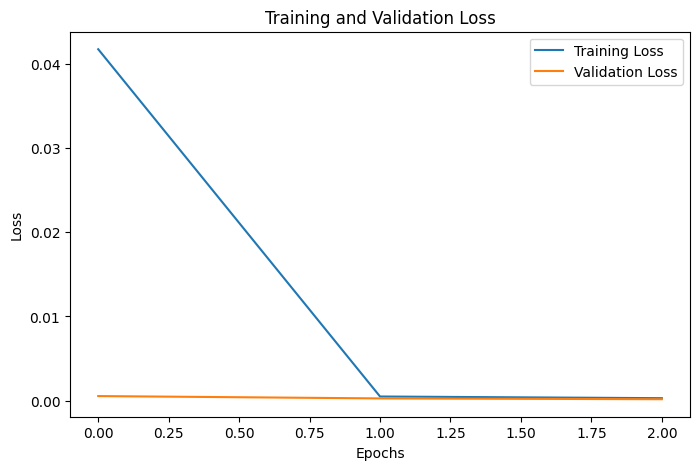

In [ ]:
# 8. Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# 9. Save the model
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
model.save_pretrained(SAVE_PATH)
tokenizer.save_pretrained(SAVE_PATH)

print(f"Model saved at {SAVE_PATH}")

Model saved at /content/drive/MyDrive/CNN_Dataset_Preprocessing/extractive_model


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')  # Download the punkt tokenizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Load SpaCy model for sentence segmentation
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
# 1. Load the saved model and tokenizer
SAVE_PATH = '/content/drive/MyDrive/CNN_Dataset_Preprocessing/extractive_model'  # Path to your saved model
model = BertForSequenceClassification.from_pretrained(SAVE_PATH)
tokenizer = BertTokenizer.from_pretrained(SAVE_PATH)

In [ ]:
# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
def generate_extractive_summary(text, max_length=3, threshold=0.5):
    # Process the article with SpaCy
    doc = nlp(text)

    # Split the article into sentences using SpaCy
    sentences = [sent.text.strip() for sent in doc.sents]

    # Tokenize the sentences using BERT tokenizer
    inputs = tokenizer(sentences, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get predictions from the model
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get the raw logits
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)[:, 1]  # Get probability for class 1 (important)

    # Print probabilities to debug
    print("Probabilities for each sentence:")
    print(probabilities)

    # Select sentences with probabilities greater than the threshold
    important_sentences = [sentences[i] for i in range(len(sentences)) if probabilities[i] > threshold]

    # Limit the summary to max_length sentences
    summary = ' '.join(important_sentences[:max_length])

    return summary


In [ ]:
article = """
Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the natural intelligence displayed by humans and animals.
Leading AI textbooks define the field as the study of "intelligent agents": any device that perceives its environment and takes actions that maximize its chance of successfully achieving its goals.
AI is a field of computer science that aims to create machines capable of performing tasks that typically require human intelligence.
The term "artificial intelligence" is often used to describe machines that mimic cognitive functions such as learning and problem-solving.
In recent years, AI has become increasingly important in various sectors, including healthcare, finance, and education.
"""

In [ ]:
# Generate extractive summary with custom threshold
summary = generate_extractive_summary(article, max_length=3, threshold=0.1)  # Set threshold to 0.5
print("Extractive Summary:")
print(summary)

Probabilities for each sentence:
tensor([0.0074, 0.0024, 0.0099, 0.0132, 0.0029, 0.0125])
Extractive Summary:



In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Example: Load a pre-trained BERT model
model_name = "bert-base-uncased"  # Replace with your extractive model name
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Define the directory where you want to save the model
save_directory = "./extractive_saved_model"

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)


('./extractive_saved_model/tokenizer_config.json',
 './extractive_saved_model/special_tokens_map.json',
 './extractive_saved_model/vocab.txt',
 './extractive_saved_model/added_tokens.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')